In [11]:
from pyecsca.ec.params import DomainParameters, get_params
from pyecsca.ec.mult import *
from pyecsca.sca.re.rpa import MultipleContext, rpa_distinguish, RPA
from pyecsca.ec.context import DefaultContext, local
from pyecsca.ec.model import ShortWeierstrassModel
from pyecsca.ec.coordinates import AffineCoordinateModel
from random import randint
import matplotlib.pyplot as plt 
from bs4 import BeautifulSoup
import pickle

In [116]:
model = ShortWeierstrassModel()
coords = model.coordinates["projective"]
add = coords.formulas["add-2007-bl"]  # The formulas are irrelevant
dbl = coords.formulas["dbl-2007-bl"]
neg = coords.formulas["neg"]


# All dbl-and-add multipliers from https://github.com/J08nY/pyecsca/blob/master/pyecsca/ec/mult

window_mults = [SlidingWindowMultiplier(add,dbl,4), SlidingWindowMultiplier(add,dbl,5), SlidingWindowMultiplier(add,dbl,6),\
                FixedWindowLTRMultiplier(add,dbl,4), FixedWindowLTRMultiplier(add,dbl,5), FixedWindowLTRMultiplier(add,dbl,6),\
                WindowBoothMultiplier(add,dbl,neg,4), WindowBoothMultiplier(add,dbl,neg,5), WindowBoothMultiplier(add,dbl,neg,6)]
naf_mults = [WindowNAFMultiplier(add,dbl,neg,4),WindowNAFMultiplier(add,dbl,neg,5),WindowNAFMultiplier(add,dbl,neg,6),BinaryNAFMultiplier(add,dbl,neg)]
comb_mults = [CombMultiplier(add,dbl,4), \
             CombMultiplier(add,dbl,5), \
             CombMultiplier(add,dbl,6), \
             BGMWMultiplier(add,dbl,4),\
             BGMWMultiplier(add,dbl,5),\
             BGMWMultiplier(add,dbl,6)]
binary_mults = [LTRMultiplier(add,dbl), RTLMultiplier(add,dbl), CoronMultiplier(add,dbl)]
other_mults = [SimpleLadderMultiplier(add,dbl), FullPrecompMultiplier(add,dbl)]
with_precomputation = window_mults + naf_mults[:-1] + other_mults[:-1]+comb_mults

all_mults = window_mults+naf_mults+binary_mults+other_mults+comb_mults



In [203]:
def get_small_scalars(category, curve_name,mult, scalar, precomp_only = False):
    
    multiples = {}
    params = get_params(category, curve_name, "projective")
    with local(MultipleContext()) as ctx:
        mult.init(params, params.generator)
        if not precomp_only:
            res = mult.multiply(scalar)
    for m in ctx.points.values():
        s = multiples.setdefault(m, set())
        s.add(mult)
    return list(ctx.points.values())

def divides_any(l,small_scalars):
    for s in small_scalars:
        if s%l==0:
            return True
    return False

def mult_label(mult):
    try:
        return f"{mult.__class__.__name__}_{getattr(mult, 'width')}"
    except AttributeError:
        return mult.__class__.__name__

def mult_color(mult):
    if mult in window_mults:
        return matplotlib.colormaps["Blues"](40+20*window_mults.index(mult))#*32/len(window_mults))
    if mult in naf_colors:
        return matplotlib.colormaps["Reds"](128+naf_colors.index(mult)*128/len(naf_colors))
    if mult in comb_colors:
        return matplotlib.colormaps["Greens"](128+comb_colors.index(mult)*128/len(comb_colors))
    if mult in binary_colors:
        return matplotlib.colormaps["pink"](128+binary_colors.index(mult)*128/len(binary_colors))
    if mult in other_colors:
        return matplotlib.colormaps["Purples_r"](128+other_colors.index(mult)*128/len(other_colors))

def get_general_distributions(divisor, bits, samples = 1000):
    distributions = {l:0 for l in divisors}
    for _ in range(samples):
        big_scalar = randint(1,2**bits)
        for l in divisors:
            if big_scalar%l==0:
                distributions[l]+=1
    for l,v in distributions.items():
        distributions[l] = v/samples
    return distributions

def get_small_scalar_distributions(mult,category,curve, divisors, bits, samples = 100, precomp_only = False):
    small_scalars_distributions = {l:0 for l in divisors}
    for _ in range(samples):
        big_scalar = randint(1,2**bits)
        small_scalars = get_small_scalars(category,curve,mult,big_scalar, precomp_only)
        for l in divisors:
            if divides_any(l, small_scalars):
                small_scalars_distributions[l]+=1
    for l,v in small_scalars_distributions.items():
        small_scalars_distributions[l] = v/samples
    return small_scalars_distributions



In [113]:
#2<p<200
small_primes = [3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199]
#200<p<400

medium_primes = [211, 223, 227, 229, 233, 239, 241, 251, 257, 263, 269, 271, 277, 281, 283, 293, 307, 311, 313, 317, 331, 337, 347, 349, 353, 359, 367, 373, 379, 383, 389, 397]

powers_of_two = [4, 8, 16, 32, 64, 128, 256, 512]

all_divisors = small_primes+medium_primes+powers_of_two


In [204]:
category = "secg"
curve="secp256r1"
bits = 256
samples = 1000
selected_mults = all_mults
selected_divisors = all_divisors

# distributions_mults = {mult:get_small_scalar_distributions(mult,category,curve,selected_divisors,bits, samples) for mult in selected_mults}
# distributions_mults_precomp = {mult:get_small_scalar_distributions(mult,category,curve,selected_divisors,bits,samples,precomp_only=True) for mult in with_precomputation}
# with open(f"distributions_{category}_{curve}_{bits}","wb") as h:
#     pickle.dump(distributions_mults, h)
# with open(f"distributions_{category}_{curve}_{bits}_precomp","wb") as h:
#     pickle.dump(distributions_mults_precomp, h)

general_distributions = get_general_distributions(selected_divisors, bits, samples)

with open(f"distributions_{category}_{curve}_{bits}","rb") as h:
    distributions_mults = pickle.load(h)
with open(f"distributions_{category}_{curve}_{bits}_precomp","rb") as h:
    distributions_mults_precomp = pickle.load(h)

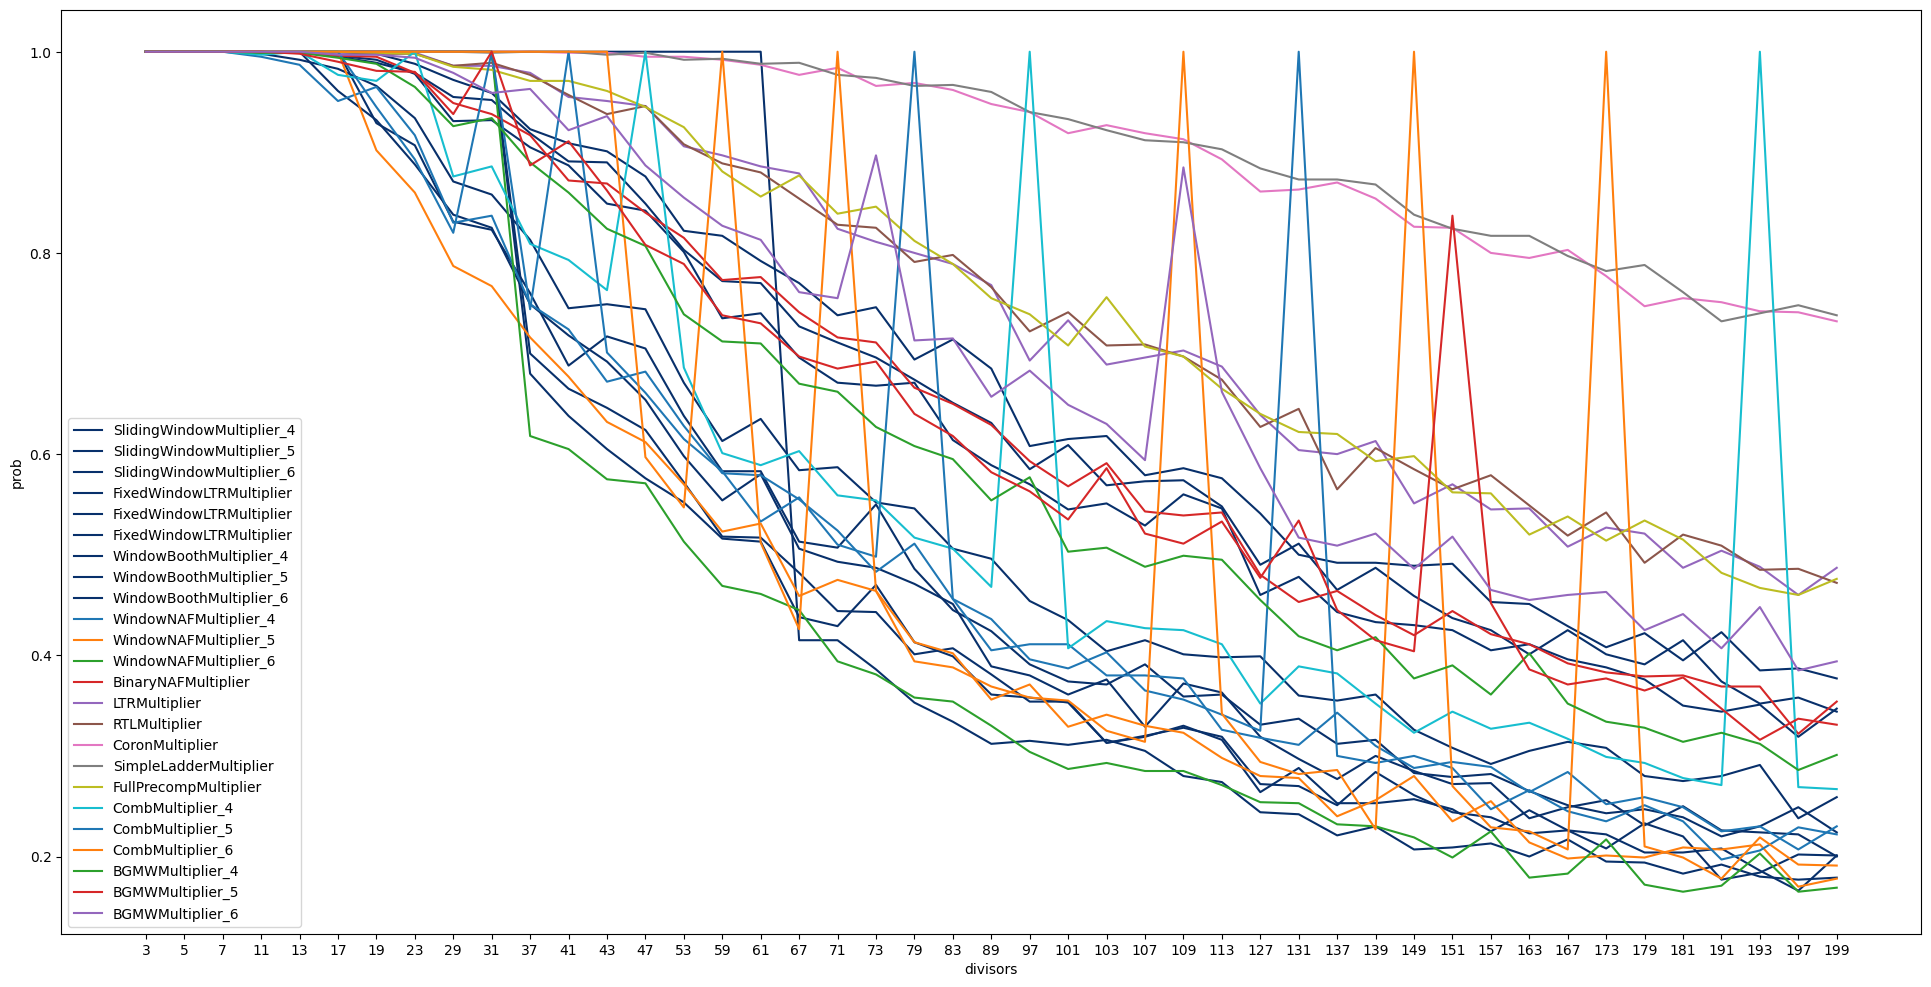

In [124]:

selected_mults = all_mults
selected_divisors = small_primes#all_divisors


fig = plt.subplots(figsize =(24, 12)) 

L = len(selected_divisors)
selected_divisors = sorted(selected_divisors)
for mult in selected_mults:
    plt.plot([l for l in range(L)],[distributions_mults[mult][l] for l in selected_divisors],color = mult_color(mult), label = mult_label(mult))

plt.xlabel('divisors') 
plt.ylabel("prob") 
plt.xticks([r for r in range(L)], selected_divisors)

plt.legend()
plt.show() 

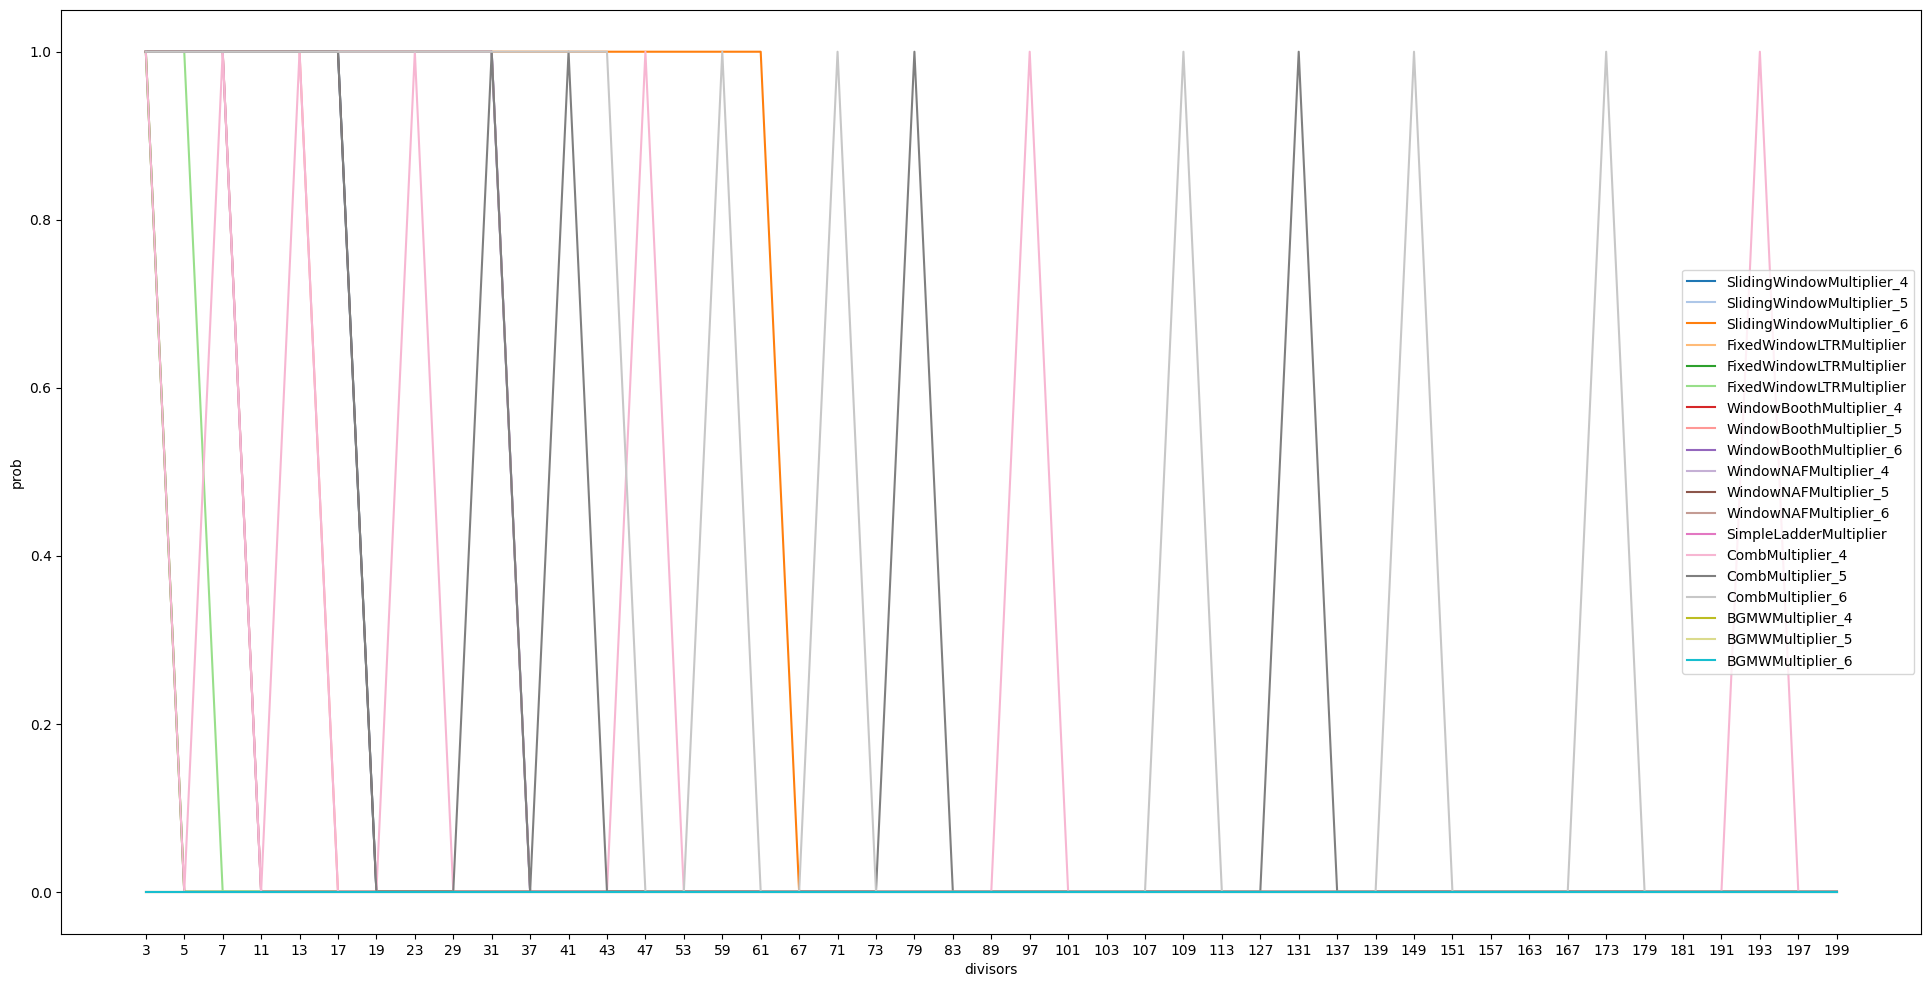

In [180]:
selected_mults = with_precomputation
selected_divisors = small_primes#all_divisors
colors = {mult:matplotlib.cm.tab20(range(len(selected_mults)))[i] for i,mult in enumerate(selected_mults)}


fig = plt.subplots(figsize =(24, 12)) 

L = len(selected_divisors)
selected_divisors = sorted(selected_divisors)
for mult in selected_mults:
    plt.plot([l for l in range(L)],[distributions_mults_precomp[mult][l] for l in selected_divisors],color = colors[mult], label = mult_label(mult))

plt.xlabel('divisors') 
plt.ylabel("prob") 
plt.xticks([r for r in range(L)], selected_divisors)

plt.legend()
plt.show() 

In [210]:
def nok_ecdh(line):
    return int(line.split(";")[-1].strip(),16)==0

def measured_distribution(library, selected_divisors):
    measured_distribution = {}
    counts = {order:0 for order in selected_divisors}
    for div in selected_divisors:
        errors = 0
        with open(f"./ecdh/{library}/ecdh_{div}.txt") as f:
            for line in f.readlines()[1:]:
                if nok_ecdh(line):
                    errors+=1
                counts[div]+=1
        measured_distribution[div] = errors
    
    for o,v in measured_distribution.items():
        if counts[o]!=0:
            measured_distribution[o] = v/counts[o]
    return measured_distribution

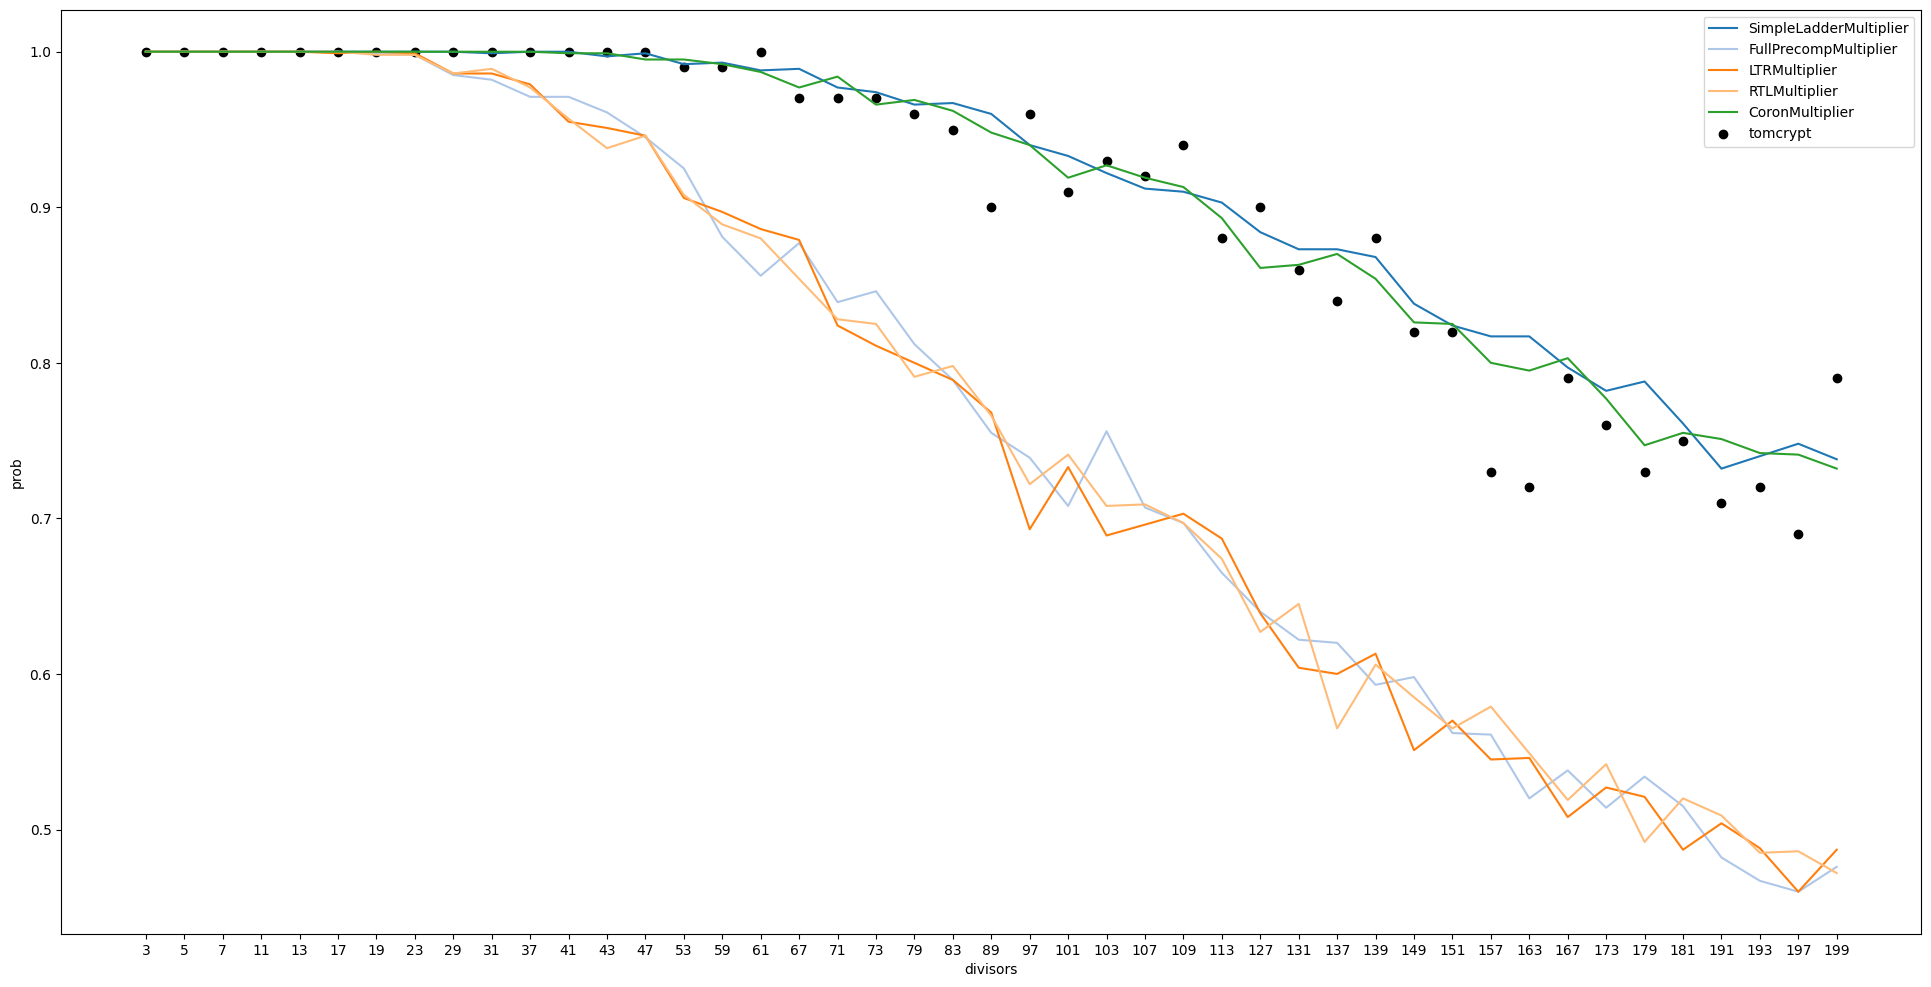

In [215]:
selected_mults = other_mults+binary_mults
selected_divisors = small_primes#all_divisors
library = "tomcrypt"
colors = {mult:matplotlib.cm.tab20(range(len(selected_mults)))[i] for i,mult in enumerate(selected_mults)}

fig = plt.subplots(figsize =(24, 12)) 

L = len(selected_divisors)
selected_divisors = sorted(selected_divisors)
for mult in selected_mults:
    plt.plot([l for l in range(L)],[distributions_mults[mult][l] for l in selected_divisors],color = colors[mult], label = mult_label(mult))


measured_dist = measured_distribution(library,selected_divisors)
mes_x, mes_y = [],[]
for i,l in enumerate(selected_divisors):
    if l in measured_dist:
        mes_y.append(measured_dist[l])
        mes_x.append(i)
plt.scatter(mes_x,mes_y,color = "black", label = library)


plt.xlabel('divisors') 
plt.ylabel("prob") 
plt.xticks([r for r in range(L)], selected_divisors)
plt.legend(loc="upper right")
plt.show() 
fig[0].savefig(f"graphs/{library}/re.png",dpi=300)

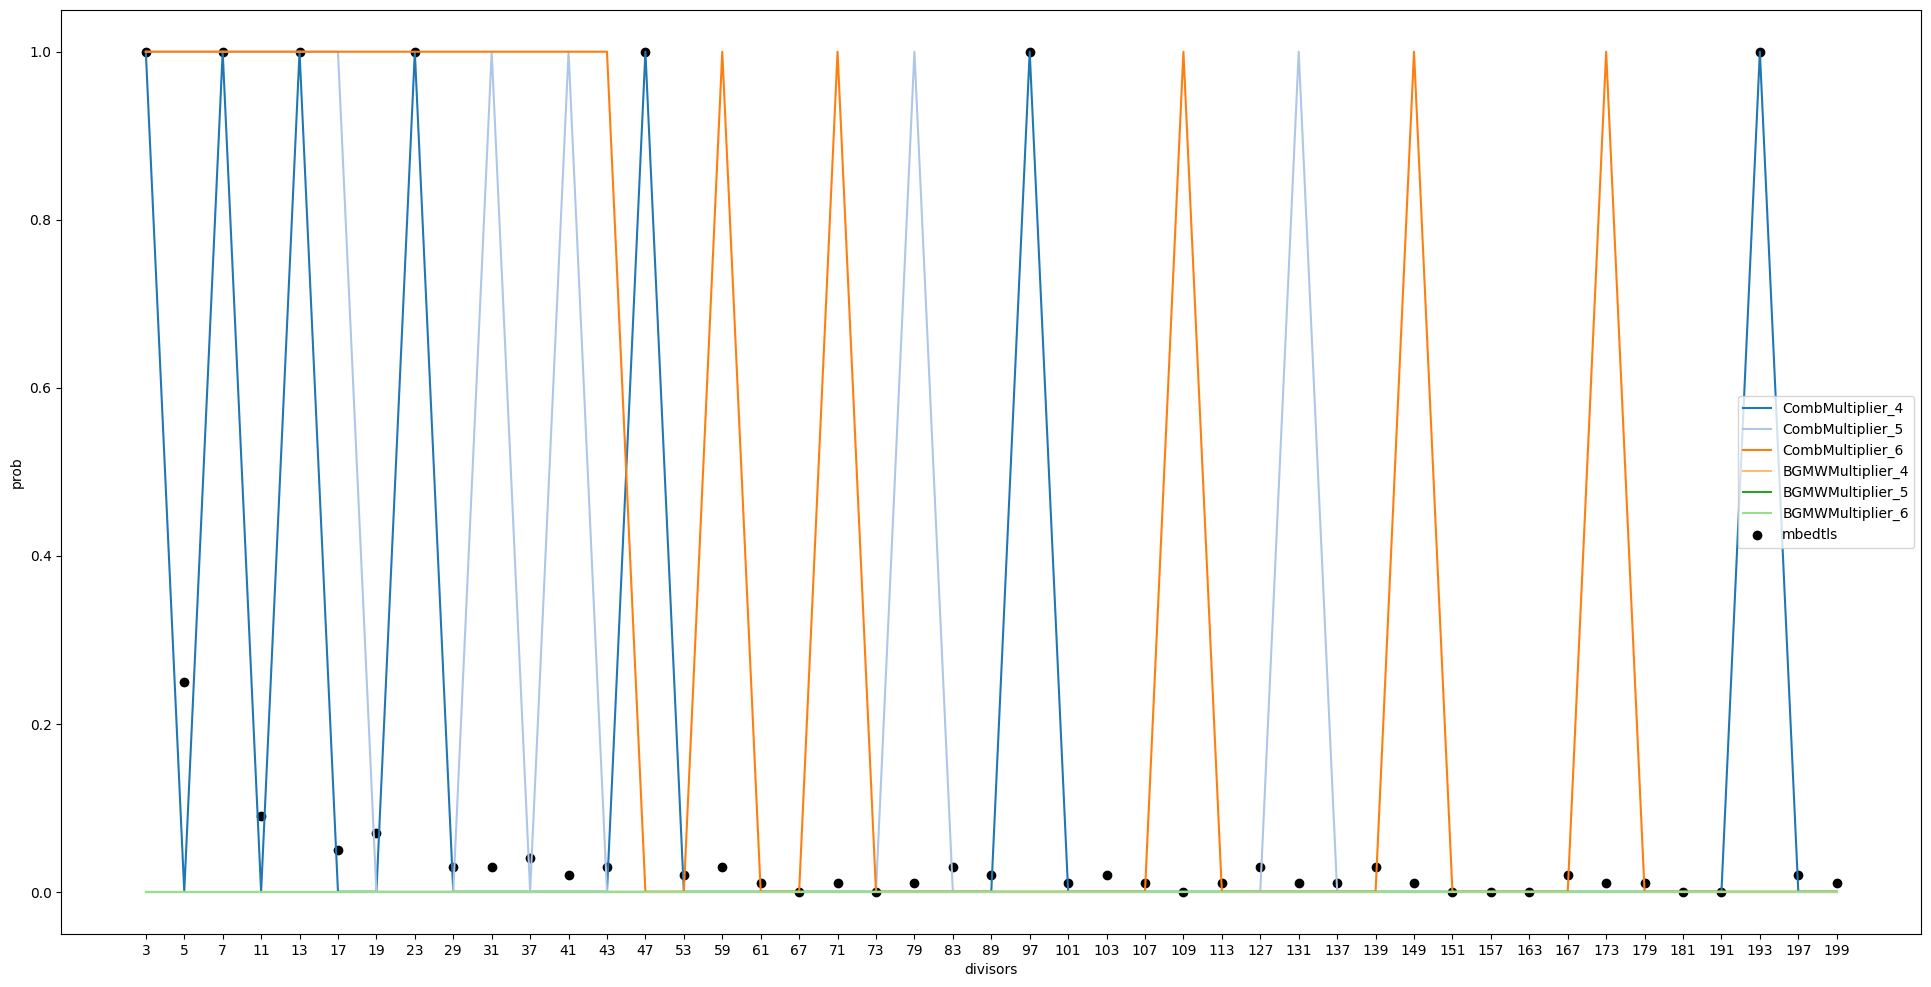

In [197]:
selected_mults = [mult for mult in with_precomputation if mult in comb_mults]
selected_divisors = small_primes#all_divisors
library = "mbedtls"
colors = {mult:matplotlib.cm.tab20(range(len(selected_mults)))[i] for i,mult in enumerate(selected_mults)}

fig = plt.subplots(figsize =(24, 12)) 

L = len(selected_divisors)
selected_divisors = sorted(selected_divisors)
for mult in selected_mults:
    plt.plot([l for l in range(L)],[distributions_mults_precomp[mult][l] for l in selected_divisors],color = colors[mult], label = mult_label(mult))


measured_dist = measured_distribution(library,selected_divisors)
mes_x, mes_y = [],[]
for i,l in enumerate(selected_divisors):
    if l in measured_dist:
        mes_y.append(measured_dist[l])
        mes_x.append(i)
plt.scatter(mes_x,mes_y,color = "black", label = library)

plt.xlabel('divisors') 
plt.ylabel("prob") 
plt.xticks([r for r in range(L)], selected_divisors)
plt.legend()
plt.show() 
fig[0].savefig(f"graphs/{library}/re.png",dpi=300)

BouncyCastle
 - WindowBooth-5?

Mbedtls
 - CombMultiplier-4
 - confirmed in library
   
tomcrypt
 - ladder or coron
 - ladder confirmed in library

OpenSSL, LibreSSL, Botan, Crypto++ and IPPCP followed the general distribution of divisibility by the primes. So they have some countermeasure.

Note that some libraries for some orders output "Invalid algorithm parameter: Not supported.". For libcrypt, SunEC and Nettle it happened for all orders.
BoringSSL
 - "Invalid algorithm parameter: Error creating EC_GROUP, EC_GROUP_set_generator."


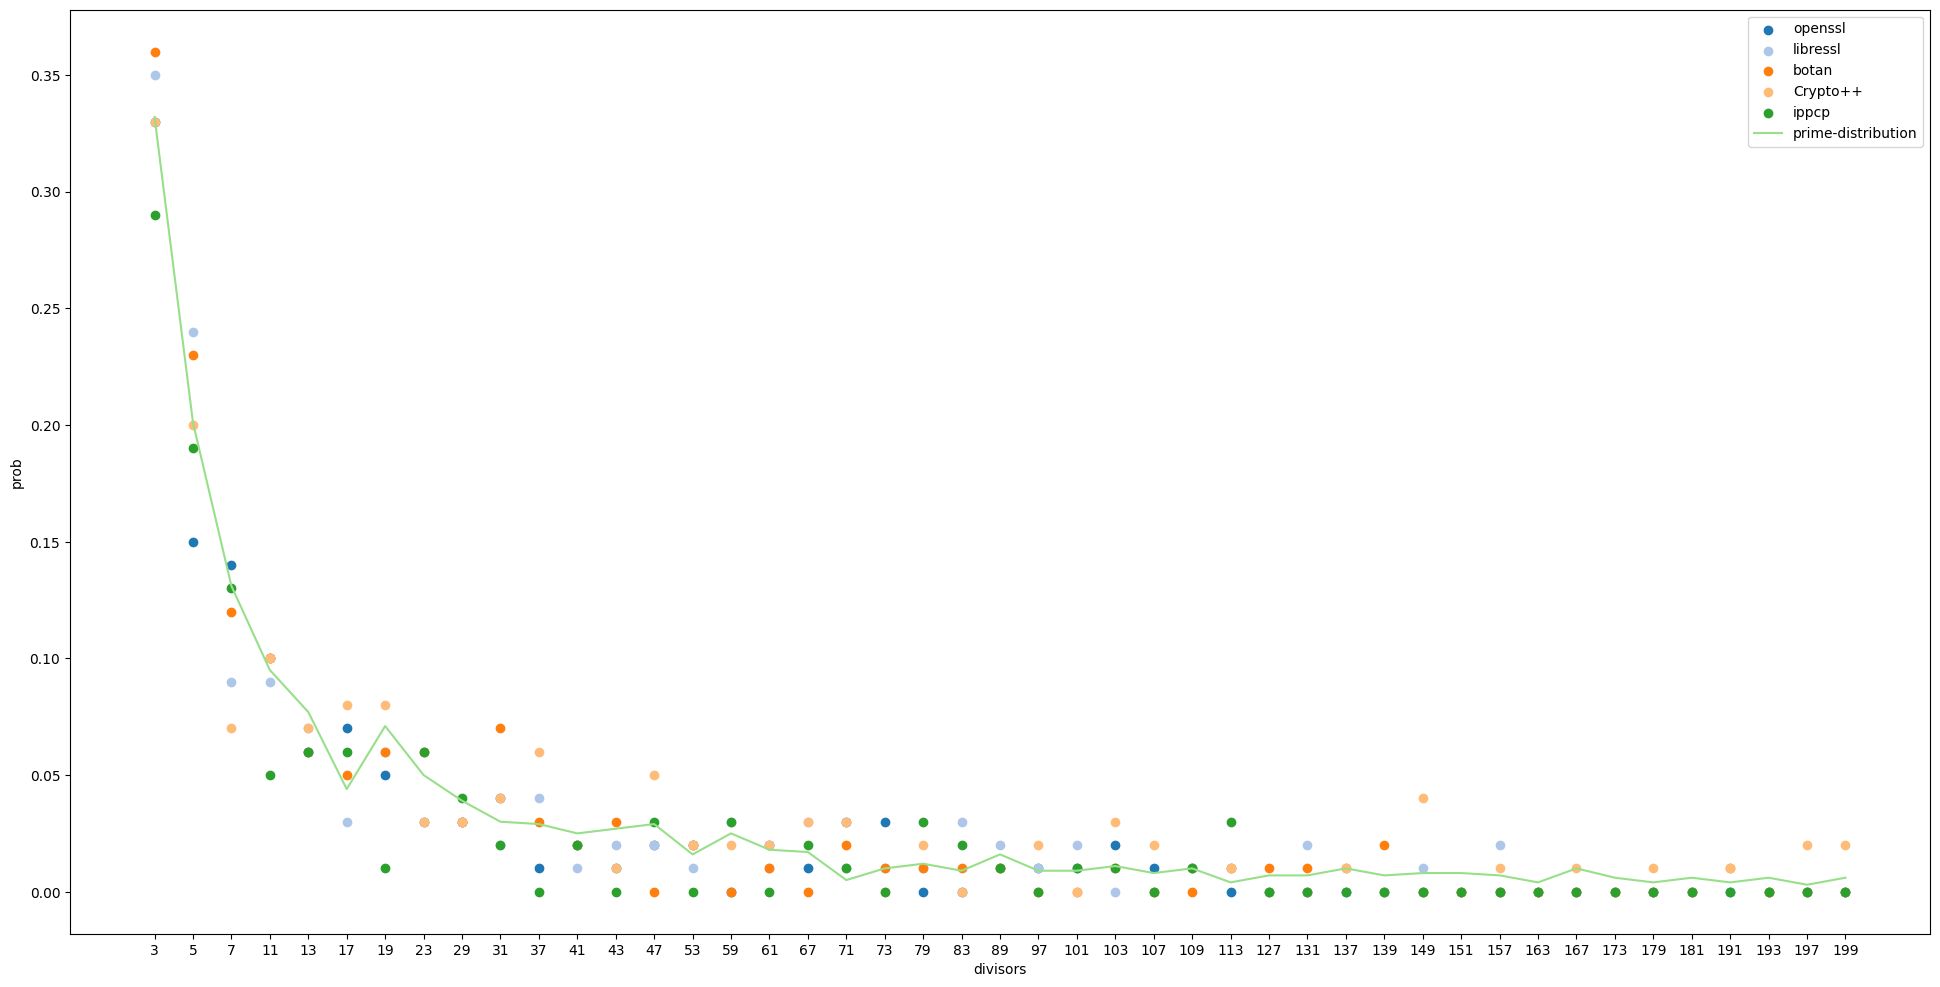

In [216]:
def scatter(library, color):
    measured_dist = measured_distribution(library,selected_divisors)
    mes_x, mes_y = [],[]
    for i,l in enumerate(selected_divisors):
        if l in measured_dist:
            mes_y.append(measured_dist[l])
            mes_x.append(i)
    plt.scatter(mes_x,mes_y,color = color, label = library)

selected_divisors = small_primes#all_divisors

fig = plt.subplots(figsize =(24, 12)) 

L = len(selected_divisors)

colors = matplotlib.cm.tab20(range(6))
scatter("openssl",colors[0])
scatter("libressl",colors[1])
scatter("botan",colors[2])
scatter("Crypto++",colors[3])
scatter("ippcp",colors[4])

plt.plot([l for l in range(L)],[general_distributions[l] for l in selected_divisors],color = colors[5], label = "prime-distribution")

plt.xlabel('divisors') 
plt.ylabel("prob") 
plt.xticks([r for r in range(L)], selected_divisors)
plt.legend()
plt.show() 
fig[0].savefig(f"graphs/resistant.png",dpi=300)